# Bagging Exercises

## Introduction

We will be using the customer churn data from the telecom industry that we used in week 1 for this week's exercises. The data file is called `Orange_Telecom_Churn_Data.csv`. 

In [18]:
from __future__ import print_function
import os
data_path = ['F:\Essential Files\Coding Projects\Machine Learning Class 1']

## Question 1

* Import the customer churn data, which is found in the file `Orange_Telecom_Churn_Data.csv`. 
* Remove any columns that are likely not to be used for prediction.
* Encode data types as appropriate.

In [19]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The prediction should definitely not include phone number. And it is unlikely that area code or state would be desired, unless there is some reason to assume the model has a very specific geographic factor.

In [20]:
data = data.drop(['phone_number', 'area_code', 'state'], axis=1)
data.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Examine the data types. Everything looks OK other than `int_plan` and `voice_mail_plan` need to be boolean encoded.

In [21]:
for col in ['intl_plan', 'voice_mail_plan']:
    data[col] = data[col].replace('yes','True').replace('no','False').astype(np.bool)
    
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

## Question 2

* Examine distribution of the predicted variable (`churned`).
* Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution.
* Examine the distribution of the predictor variable in the train and test data.

In [22]:
data.churned.value_counts()

False    4293
True      707
Name: churned, dtype: int64

In [23]:
data.churned.value_counts(normalize=True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

Given the skew in the predictor variable, let's split the data with the *churned* values being stratified.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

feature_cols = [x for x in data.columns if x != 'churned']

SSS = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)

train_idx, test_idx = next(SSS.split(data[feature_cols], data['churned']))

X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'churned']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'churned']

In [25]:
y_train.value_counts(normalize=True)

False    0.858571
True     0.141429
Name: churned, dtype: float64

In [26]:
y_test.value_counts(normalize=True)

False    0.858667
True     0.141333
Name: churned, dtype: float64

## Question 3

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [27]:
# Suppress warnings about too few trees from the early models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [30]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)

oob_list = list()

for n_trees in [15, 20, 30, 40, 50, 100 ,150, 200 ,300 ,400]:
    RF.set_params(n_estimators=n_trees)
    RF.fit(X_train, y_train)
    
    oob_error = 1 - RF.oob_score_
    
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    
rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df
    

,oob
n_trees,
15.0,0.092286
20.0,0.084857
30.0,0.080857
40.0,0.077429
50.0,0.077714
100.0,0.072857
150.0,0.072571
200.0,0.073143
300.0,0.072000


The error looks like it has stabilized around 100-150 trees.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

[Text(0, 0.5, 'out-of-bag error')]

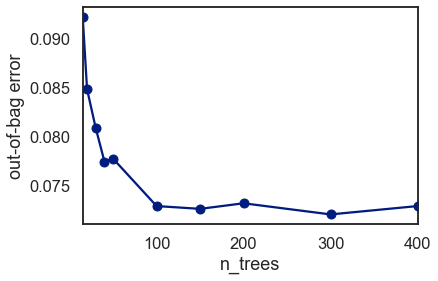

In [32]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error')

## Question 4

* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

In [33]:
from sklearn.ensemble import ExtraTreesClassifier

model_ET = ExtraTreesClassifier(n_estimators=100, random_state=42,
                                  warm_start=True, oob_score=True, bootstrap=True, n_jobs=-1)


oob_score_list = list()

for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]:
    model_ET.set_params(n_estimators = n_trees)
    model_ET.fit(X_train, y_train)
    
    oob_error = 1 - model_ET.oob_score_
    oob_score_list.append(pd.Series({'number of trees' : n_trees, 'out of bag error' : oob_error}))
    

ET_oob_df = pd.concat(oob_score_list, axis=1).T.set_index('number of trees')

ET_oob_df

,out of bag error
number of trees,
15.0,0.099714
20.0,0.097143
30.0,0.090000
40.0,0.086571
50.0,0.082286
100.0,0.078000
150.0,0.082286
200.0,0.081143
250.0,0.079429


Combine the two dataframes into a single one for easier plotting.

In [35]:
ET_oob_df = pd.concat([rf_oob_df.rename(columns={'oob': 'RandomForest'}), ET_oob_df.rename(columns={'oob':'ExtraTrees'})],axis=1)
ET_oob_df

,RandomForest,out of bag error
15.0,0.092286,0.099714
20.0,0.084857,0.097143
30.0,0.080857,0.090000
40.0,0.077429,0.086571
50.0,0.077714,0.082286
100.0,0.072857,0.078000
150.0,0.072571,0.082286
200.0,0.073143,0.081143
250.0,NaN,0.079429
300.0,0.072000,0.080571


The random forest model performs consistently better than the extra randomized trees.

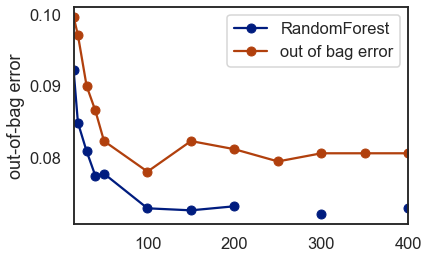

In [36]:
ax = ET_oob_df.plot(marker='o')
ax.set(ylabel='out-of-bag error');

## Question 5

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [37]:
model = RF.set_params(n_estimators=100)

y_pred = model.predict(X_test)

Unsurprisingly, recall is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.932 (vs 0.85 for random guessing).

In [38]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                        'precision': precision_score(y_test, y_pred),
                        'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                        'auc': roc_auc_score(y_test, y_pred)},
                       index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

       False       0.93      0.99      0.96      1288
        True       0.94      0.55      0.70       212

    accuracy                           0.93      1500
   macro avg       0.94      0.77      0.83      1500
weighted avg       0.93      0.93      0.92      1500

   accuracy  precision    recall        f1       auc
0     0.932   0.943548  0.551887  0.696429  0.773226


## Question 6

* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

Text(0.5, 4.5, 'Ground Truth')

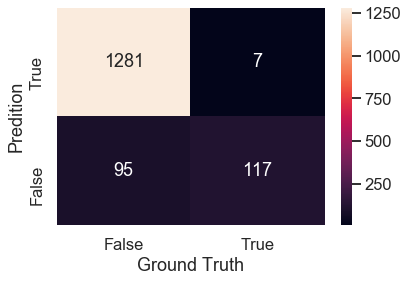

In [48]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
cm=confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels[::-1])
ax.set_ylabel('Predition')
ax.set_xlabel('Ground Truth')

The ROC-AUC and precision-recall curves.

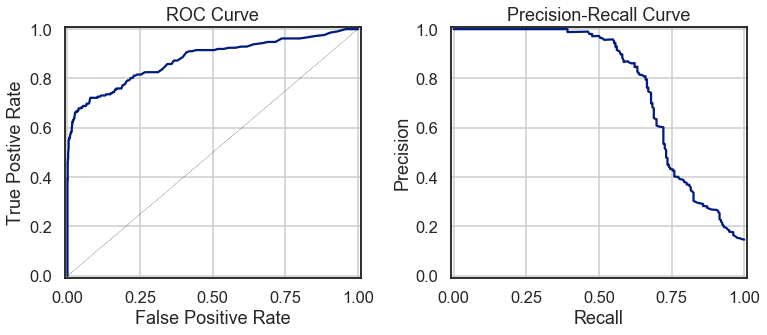

In [49]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

y_prob = RF.predict_proba(X_test)

ax = axList[0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
ax.plot(fpr, tpr)
ax.plot([0, 1], [0,1], ls='--', color='black', lw=0.3)
ax.set(xlabel='False Positive Rate',
      ylabel='True Postive Rate',
      xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],
      title='ROC Curve')
ax.grid(True)


ax = axList[1]
precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
      xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],
      title='Precision-Recall Curve')
ax.grid(True)

plt.tight_layout()

The feature importances. Total daily cost is the biggest predictor of customer churn.

[Text(0, 0.5, 'Relative Importance')]

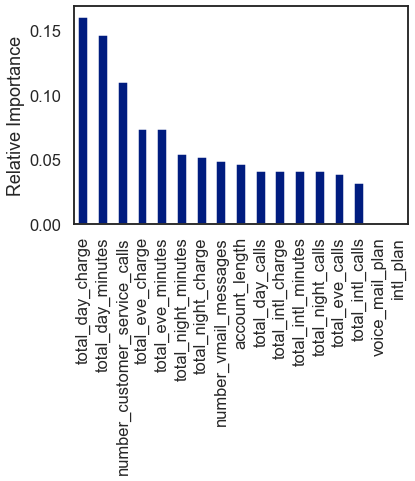

In [50]:
feature_imp = pd.Series(RF.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance')